In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from qiskit import IBMQ, assemble, transpile
from qiskit import QuantumCircuit

In [3]:
N_QUBITS = 20 # Number of qubits used in Google paper


In [4]:
# Load IBMQ cloud-based QASM simulator 
provider = IBMQ.load_account()
backend = provider.backend.ibmq_qasm_simulator

ibmqfactory.load_account:WARNING:2022-02-25 12:08:26,940: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
def random_bitstring_circuit(n_qubits: int) -> QuantumCircuit:
   
    qc = QuantumCircuit(n_qubits)
    # Generate random bitstring
    random_bitstring = np.random.randint(2, size=n_qubits)
    # Apply X gate to nonzero qubits in bitstring
    for i in range(n_qubits):
        if random_bitstring[i]:
            qc.x(i)
    return qc

In [6]:
def floquet_circuit(n_qubits: int, g: float) -> QuantumCircuit:
    
    
    qc = QuantumCircuit(n_qubits)
    
    # X rotation by g*pi on all qubits (simulates the periodic driving pulse)
    for i in range(n_qubits):
        qc.rx(g*np.pi, i)
        
    qc.barrier()
        
    # Ising interaction (only couples adjacent spins with random coupling strengths)
    for i in range(0, n_qubits-1, 2):
        phi = np.random.uniform(low=0.5, high=1.5)
        theta = -phi * np.pi / 2
        qc.rzz(theta, i, i+1)
    for i in range(1, n_qubits-1, 2):
        phi = np.random.uniform(low=0.5, high=1.5)
        theta = -phi * np.pi / 2
        qc.rzz(theta, i, i+1)
        
    qc.barrier()
        
    # Longitudinal fields for disorder
    for i in range(n_qubits):
        h = np.random.uniform(low=-1, high=1)
        qc.rz(h * np.pi, i)
        
    return qc

In [7]:
def calculate_mean_polarization(n_qubits: int, counts: dict, q_index: int) -> float:
    
    run, num_shots = 0, 0
    for bitstring in counts.keys():
        val = 1 if (int(bitstring[n_qubits-q_index-1]) == 0) else -1
        run += val * counts[bitstring]
        num_shots += counts[bitstring]
    return run / num_shots

In [8]:
def calculate_two_point_correlations(series: list) -> list:
    
    n = len(series)
    data = np.asarray(series)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        acf_lag = ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return round(acf_lag, 3)
    
    x = np.arange(n) # Avoiding lag 0 calculation
    acf_coeffs = list(map(r, x))
    return acf_coeffs

In [9]:
def simulate(n_qubits: int, initial_state: QuantumCircuit, max_time_steps: int, g: float) -> None:
    
    mean_polarizations = np.zeros((n_qubits, max_time_steps+1))
    floq_qc = floquet_circuit(n_qubits, g)
    
    for t in range(0, max_time_steps+1):
        if ((t % 5) == 0):
            print('Time t=%d' % t)
        qc = QuantumCircuit(n_qubits)
        qc = qc.compose(initial_state)
        for i in range(t):
            qc = qc.compose(floq_qc)
        qc.measure_all()
        transpiled = transpile(qc, backend)
        job = backend.run(transpiled)
        retrieved_job = backend.retrieve_job(job.job_id())
        counts = retrieved_job.result().get_counts()
        
        for qubit in range(n_qubits):
            mean_polarizations[qubit,t] = calculate_mean_polarization(n_qubits, counts, q_index=qubit)  
        
    return mean_polarizations

In [10]:
polarized_state = QuantumCircuit(N_QUBITS) # All qubits in |0> state


In [11]:
thermal_z = simulate(n_qubits=N_QUBITS,
                     initial_state=polarized_state,
                     max_time_steps=50,
                     g=0.6)

Time t=0
Time t=5
Time t=10
Time t=15
Time t=20
Time t=25
Time t=30
Time t=35
Time t=40
Time t=45
Time t=50


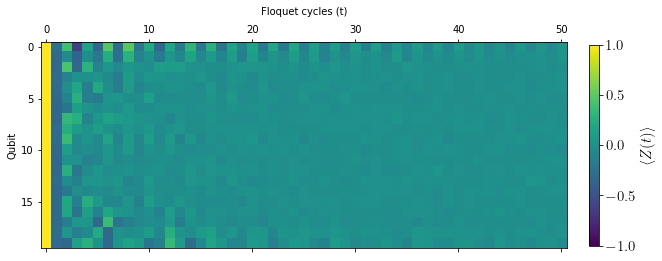

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(thermal_z, cmap='viridis')

plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True

ax.set_xlabel('Floquet cycles (t)')
ax.xaxis.labelpad = 10
ax.set_ylabel('Qubit')
ax.set_xticks(np.arange(0, 51, 10))
ax.set_yticks(np.arange(0, N_QUBITS, 5))
ax.xaxis.set_label_position('top')

im.set_clim(-1, 1)
cbar = plt.colorbar(im, fraction=0.018, pad=0.04)
cbar.set_label(r'$\langle Z(t) \rangle$')
plt.show()

Text(0, 0.5, '$\\langle Z(t) \\rangle$')

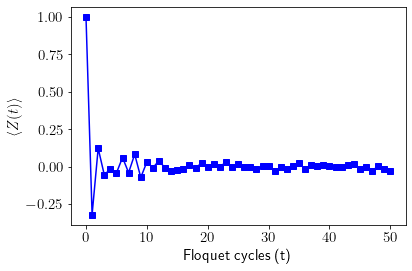

In [13]:
plt.plot(thermal_z[10,:], 'bs-')
plt.xlabel('Floquet cycles (t)')
plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
plt.ylabel(r'$\langle Z(t) \rangle$')

In [14]:
dtc_z = simulate(n_qubits=N_QUBITS, 
                 initial_state=polarized_state,
                 max_time_steps=50,
                 g=0.97)

Time t=0
Time t=5
Time t=10
Time t=15
Time t=20
Time t=25
Time t=30
Time t=35
Time t=40
Time t=45
Time t=50


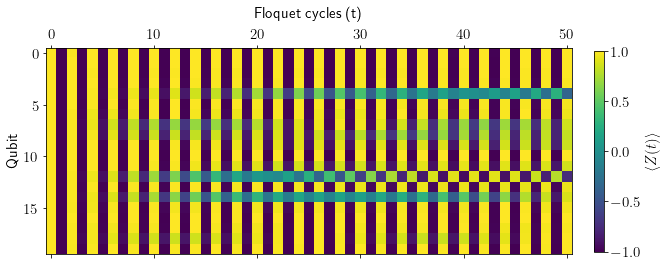

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(dtc_z, cmap='viridis')

plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True

ax.set_xlabel('Floquet cycles (t)')
ax.xaxis.labelpad = 10
ax.set_ylabel('Qubit')
ax.set_xticks(np.arange(0, 51, 10))
ax.set_yticks(np.arange(0, N_QUBITS, 5))
ax.xaxis.set_label_position('top')

im.set_clim(-1, 1)
cbar = plt.colorbar(im, fraction=0.018, pad=0.04)
cbar.set_label(r'$\langle Z(t) \rangle$')
plt.show()

Text(0, 0.5, '$\\langle Z(t) \\rangle$')

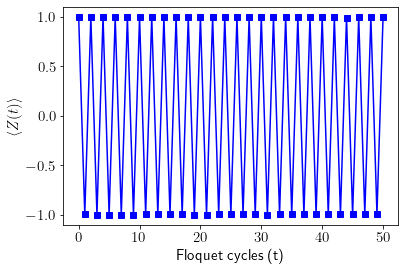

In [16]:
plt.plot(dtc_z[10,:], 'bs-')
plt.xlabel('Floquet cycles (t)')
plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
plt.ylabel(r'$\langle Z(t) \rangle$')